Use the annotated data to train a model to classify the remaining unlabelled pixels.

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np

In [2]:
!pwd

/Users/Mark/fruitpunch/coral_detection/notebooks


In [3]:
!ls ../data

14007262601.jpg                  34006105201.jpg
14007262601_colour_corrected.jpg 34008200601.jpg
14007262601_labels.png           annotations_PAC_AUS.csv
34006089701.jpg


In [4]:
image_path = '/Users/Mark/fruitpunch/coral_detection/data/'
image_file = '14007262601.jpg'

In [5]:
img = mpimg.imread(image_path + image_file)

In [6]:
annot_file = 'annotations_PAC_AUS.csv'

In [7]:
df = pd.read_csv(image_path + annot_file, index_col=0)

In [8]:
# choose only the rows corresponding to our image
id = os.path.basename(image_file).rstrip('.jpg')
id = int(id)
df = df.loc[id]

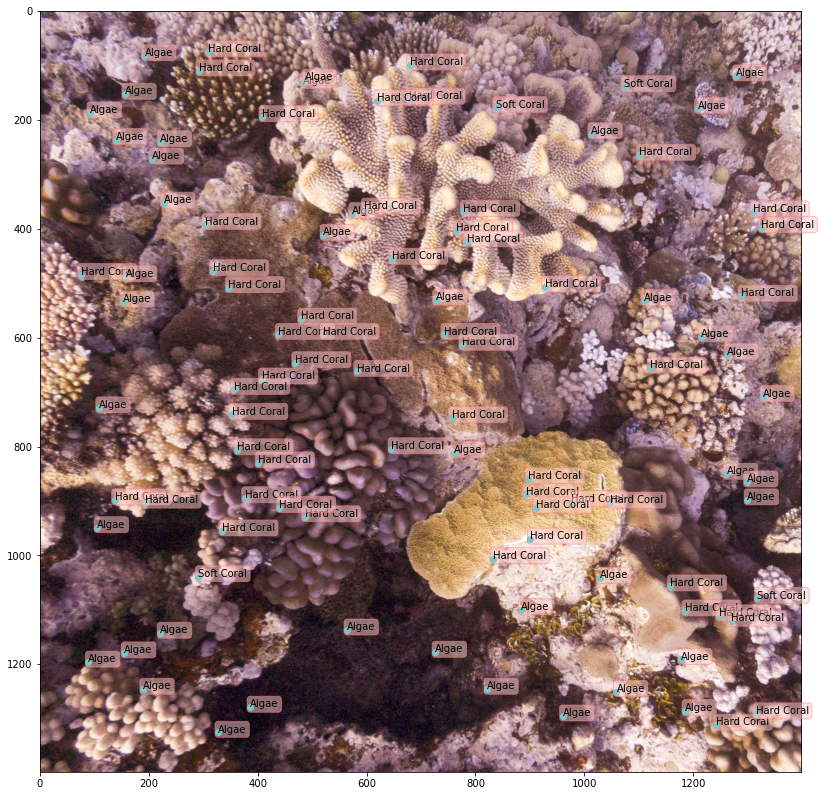

In [9]:
fig, ax = plt.subplots(1,1, figsize=(14,14))
ax.imshow(img);
ax.scatter(df["x"], df["y"], color="c");
for k, s in enumerate(df['func_group']):
  x = df["x"].iloc[k]
  y = df["y"].iloc[k]
  plt.text(x, y, s, color='k', fontsize=10, 
           bbox=dict(boxstyle="round", 
                     ec=(1., 0.5, 0.5),
                     fc=(1., 0.8, 0.8),
                     alpha=0.5))

In [10]:
# extract the rgb values from the coordinates
df[['r','g','b']] = img[df['x'], df['y'], :]

In [11]:
df.head()

,y,x,label_name,label,func_group,method,data_set,r,g,b
quadratid,,,,,,,,,,
14007262601,676,407,Acroporidae plate/encrusting,ACR-PE,Hard Coral,random,train,196,167,163
14007262601,614,775,Acroporidae plate/encrusting,ACR-PE,Hard Coral,random,train,123,86,103
14007262601,970,901,Acroporidae plate/encrusting,ACR-PE,Hard Coral,random,train,251,223,184
14007262601,888,892,Acroporidae plate/encrusting,ACR-PE,Hard Coral,random,train,166,122,57
14007262601,859,897,Acroporidae plate/encrusting,ACR-PE,Hard Coral,random,train,134,97,45


Now attempt to train a model on Algae vs non-Algae

In [12]:
df['func_group'].value_counts()

Hard Coral    54
Algae         42
Soft Coral     4
Name: func_group, dtype: int64

In [13]:
# define the target as coral or other
df['is_coral'] = ~df['func_group'].str.match('Algae')

In [14]:
df

,y,x,label_name,label,func_group,method,data_set,r,g,b,is_coral
quadratid,,,,,,,,,,,
14007262601,676,407,Acroporidae plate/encrusting,ACR-PE,Hard Coral,random,train,196,167,163,True
14007262601,614,775,Acroporidae plate/encrusting,ACR-PE,Hard Coral,random,train,123,86,103,True
14007262601,970,901,Acroporidae plate/encrusting,ACR-PE,Hard Coral,random,train,251,223,184,True
14007262601,888,892,Acroporidae plate/encrusting,ACR-PE,Hard Coral,random,train,166,122,57,True
14007262601,859,897,Acroporidae plate/encrusting,ACR-PE,Hard Coral,random,train,134,97,45,True
...,...,...,...,...,...,...,...,...,...,...,...
14007262601,412,520,Epilithic Algal Matrix,Unc,Algae,random,train,92,54,53,False
14007262601,865,1298,Epilithic Algal Matrix,Unc,Algae,random,train,161,119,131,False
14007262601,898,1299,Epilithic Algal Matrix,Unc,Algae,random,train,181,142,147,False


In [15]:
df['is_coral'].value_counts()

True     58
False    42
Name: is_coral, dtype: int64

Now the modelling

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[['r','g','b']], 
                                                    df['is_coral'], 
                                                    train_size=0.7)

In [17]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier().fit(X_train, y_train)

In [18]:
rfc.score(X_test, y_test)

0.5333333333333333

In [19]:
y_pred = rfc.predict(img.reshape((-1,3))).reshape(img.shape[0:-1])

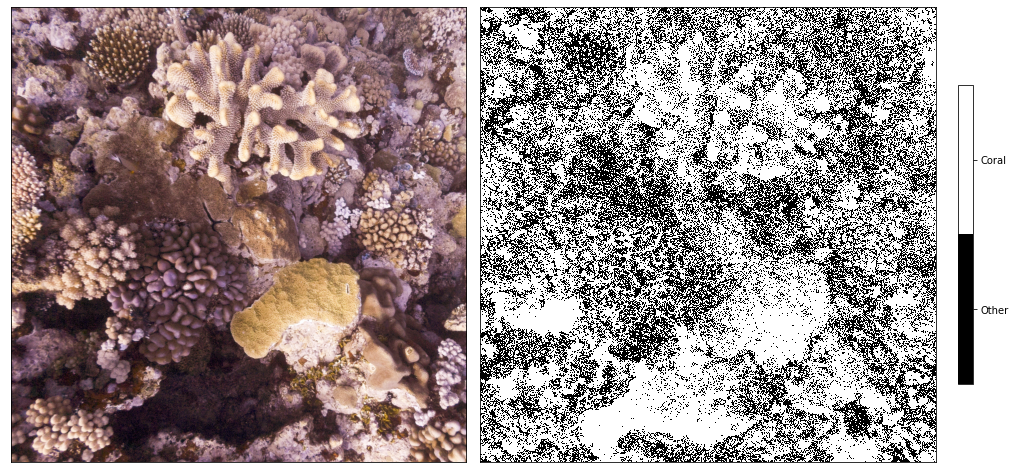

In [25]:
import matplotlib.colors

cmap = matplotlib.colors.ListedColormap(['black','w'])

fig, ax = plt.subplots(1,2,figsize=(14,7), constrained_layout=True)
ax[0].imshow(img);
im = ax[1].imshow(y_pred, cmap=cmap, interpolation='None');
for tax in ax:
    tax.axes.xaxis.set_visible(False)
    tax.axes.yaxis.set_visible(False)

cbar = fig.colorbar(im, ax=ax[1], shrink=0.6, ticks=[0.25, 0.75]);
cbar.ax.set_yticklabels(['Other','Coral']);

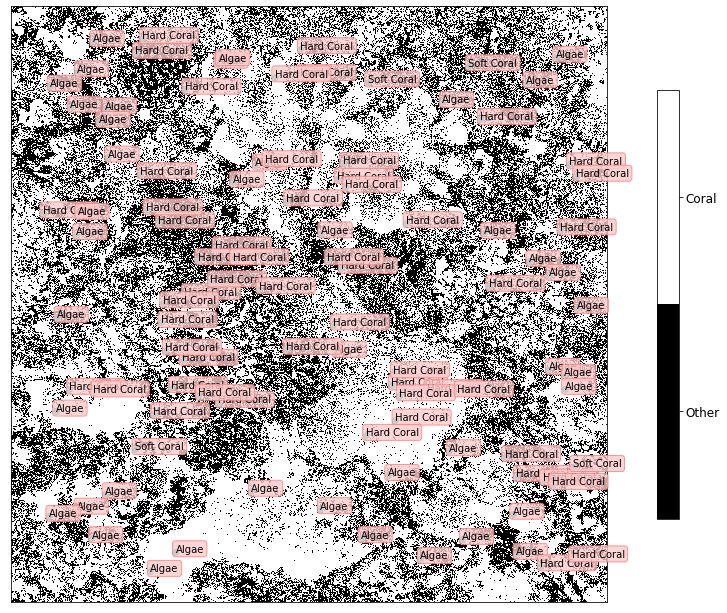

In [43]:
fig, ax = plt.subplots(1,1,figsize=(10,10), constrained_layout=True)
ax.imshow(y_pred, cmap=cmap, interpolation='None');
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
cbar = fig.colorbar(im, ax=ax, shrink=0.6, ticks=[0.25, 0.75]);
cbar.ax.set_yticklabels(['Other','Coral'], fontsize=12);

ax.scatter(df["x"], df["y"], color="c");
for k, s in enumerate(df['func_group']):
  x = df["x"].iloc[k]
  y = df["y"].iloc[k]
  plt.text(x, y, s, color='k', fontsize=10, 
           bbox=dict(boxstyle="round", 
                     ec=(1., 0.5, 0.5),
                     fc=(1., 0.8, 0.8),
                     alpha=0.8))

In [29]:
y_pred.shape

(1398, 1398)

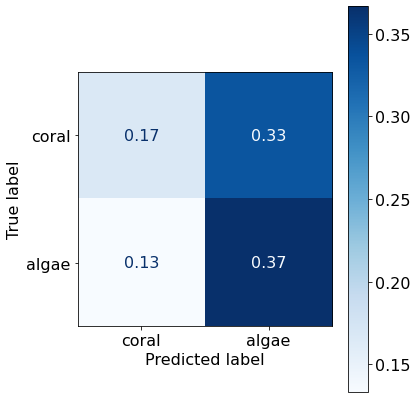

In [45]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# confusion_matrix(y_true, y_pred)
# confusion_matrix(y_test, rfc.predict(X_test)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
plot_confusion_matrix(rfc, X_test, y_test, ax=ax,
                      cmap=plt.cm.Blues, normalize='all',
                      display_labels=["coral","algae"])
plt.tight_layout()
fig.savefig("/Users/Mark/Desktop/conf_matrix.png", facecolor="w", edgecolor='none')
plt.show()

Some preliminary hyperparameter tuning

In [41]:
train_scores = []
test_scores = []

for n in range(1,100):
    rf = RandomForestClassifier(n_estimators = 20, max_depth=n)
    rf.fit(X_train,y_train)
    
    train_scores.append(rf.score(X_train,y_train))
    test_scores.append(rf.score(X_test,y_test))    

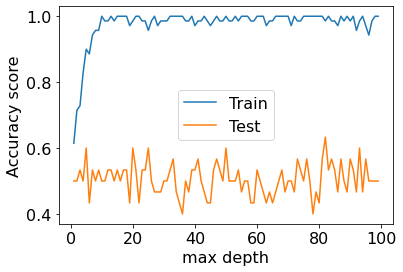

In [42]:
plt.figure()
plt.plot(range(1,100), train_scores, label="Train")
plt.plot(range(1,100), test_scores, label="Test")
plt.xlabel('max depth')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()